# Load the data and define the functions

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

def lorentzian(x, gamma):
    return gamma / (np.pi * (x**2 + gamma**2))

def linear_bg(x, m, q):
    return m * x + q

def pseudo_voigt(x, amplitude, center, sigma, gamma, eta):
    # Gaussian
    gaussian = norm.pdf(x, loc=center, scale=sigma)
    # Lorentzian
    lorentz = lorentzian(x - center, gamma)
    return amplitude * (eta * lorentz + (1 - eta) * gaussian)

# Combined model: pseudo-Voigt + linear background
def model_single(x, amplitude, center, sigma, gamma, eta, m, q):
    return pseudo_voigt(x, amplitude, center, sigma, gamma, eta) + linear_bg(x, m, q)

# Double peak model
def model_double(x, amplitude1, center1, sigma1, gamma1, eta1, amplitude2, center2, sigma2, gamma2, eta2, m, q):
    return (pseudo_voigt(x, amplitude1, center1, sigma1, gamma1, eta1) +
            pseudo_voigt(x, amplitude2, center2, sigma2, gamma2, eta2) +
            linear_bg(x, m, q))

def pseudo_voigt_fwhm(sigma, gamma, eta):
    # Approximate FWHM for pseudo-Voigt (Thompson, Cox & Hastings, 1987)
    f_g = 2 * sigma * np.sqrt(2 * np.log(2))  # Gaussian FWHM
    f_l = 2 * gamma                          # Lorentzian FWHM
    return ( (f_g**5 + 2.69269*f_g**4*f_l + 2.42843*f_g**3*f_l**2 +
              4.47163*f_g**2*f_l**3 + 0.07842*f_g*f_l**4 + f_l**5) ** (1/5) )

# Load data
data = np.loadtxt('./Group04/gixrd_scan05_om0p6_th30-90_G4.xy')
x_data = np.float32(data[:, 0])
y_data = np.float32(data[:, 1])


# Plot of the whole spectrum

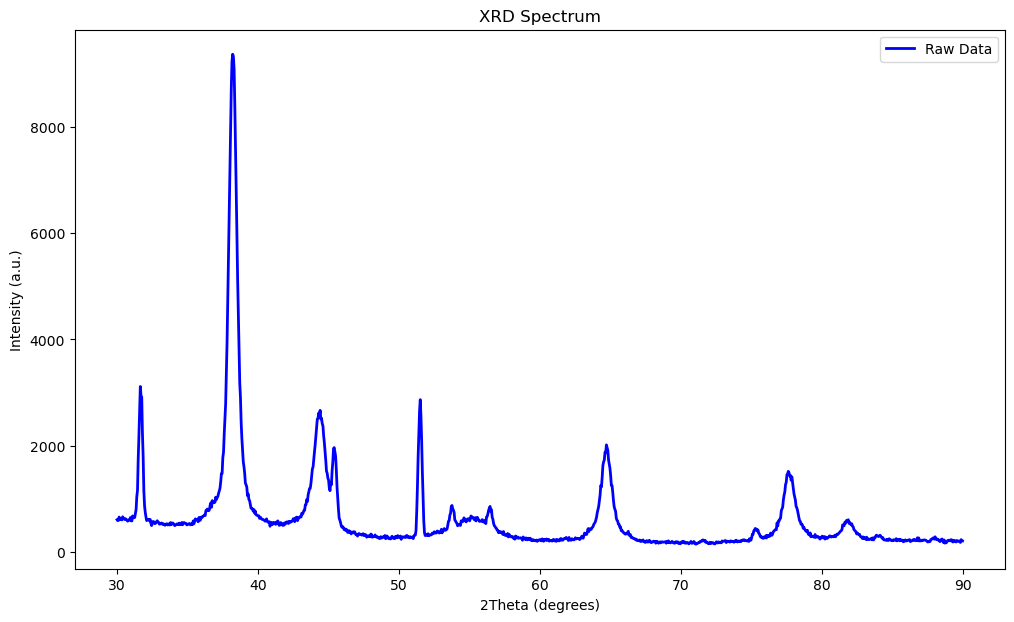

In [23]:
plt.figure(figsize=(12, 7))
plt.plot(x_data, y_data, label='Raw Data', color='blue', linewidth=2)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('XRD Spectrum')
plt.legend()
plt.show()

# Peak 1

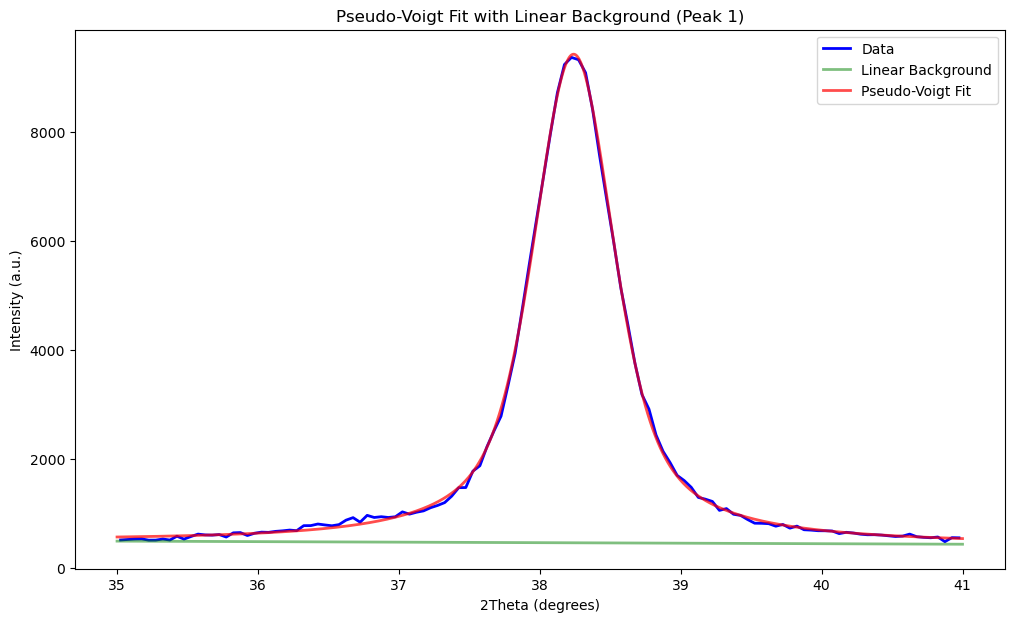

   Parameter       Value  Uncertainty
   Amplitude 8901.412781    74.009714
      Center   38.240376     0.000868
       Sigma    0.262304     0.005358
       Gamma    0.397621     0.017211
         Eta    0.713500     0.017651
Background m   -9.501071     2.950686
Background q  826.900481   110.918864

HWHM (Peak 1): 0.5719717968160226


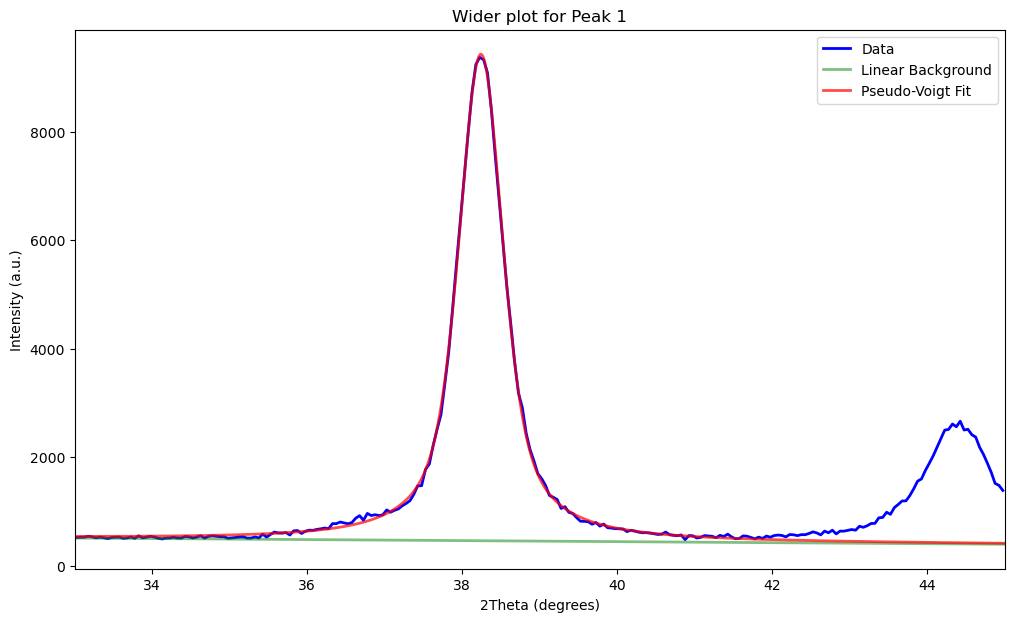

In [24]:
# Select Peak 1 region
x_begin = 35
x_end = 41
mask = (x_data > x_begin) & (x_data < x_end)
x_filtered_1 = x_data[mask]
y_filtered_1 = y_data[mask]

# Initial guess for single peak: [amplitude, center, sigma, gamma, eta, m, q]
p0_1 = [9000, 38.25, 0.2, 0.2, 0.5, 0, 500]

# Set bounds
lower_bounds_1 = [
    0, 0, 0, 0, 0,      # Peak (amplitude, center, sigma, gamma, eta)
    -np.inf, 0          # Background (m, q)
]
upper_bounds_1 = [
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak (amplitude, center, sigma, gamma, eta)
    0, np.inf                           # Background (m, q)
]
bounds_1 = (lower_bounds_1, upper_bounds_1)

# Fit single peak model to peak 1 region
p_optimal_1, p_cov_1 = curve_fit(model_single, x_filtered_1, y_filtered_1, p0=p0_1, bounds=bounds_1, maxfev=10000)
Amplitude_best_1, Center_best_1, Sigma_best_1, Gamma_best_1, Eta_best_1, m_1, q_1 = p_optimal_1

# Plot the fit
x = np.linspace(x_begin, x_end, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_filtered_1, y_filtered_1, label='Data', color='blue', linewidth=2)
plt.plot(x, linear_bg(x, m_1, q_1), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x,
    model_single(x, Amplitude_best_1, Center_best_1, Sigma_best_1, Gamma_best_1, Eta_best_1, m_1, q_1),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('Pseudo-Voigt Fit with Linear Background (Peak 1)')
plt.legend()
plt.show()

# Print the best fit parameters for Peak 1 in a table
params_1 = {
    "Parameter": [
        "Amplitude", "Center", "Sigma", "Gamma", "Eta", "Background m", "Background q"
    ],
    "Value": [
        Amplitude_best_1, Center_best_1, Sigma_best_1, Gamma_best_1, Eta_best_1, m_1, q_1
    ],
    "Uncertainty": [
        np.sqrt(p_cov_1[i, i]) for i in range(len(p_optimal_1))
    ]
}

df_params_1 = pd.DataFrame(params_1)
print(df_params_1.to_string(index=False))
print("\nHWHM (Peak 1):", pseudo_voigt_fwhm(Sigma_best_1, Gamma_best_1, Eta_best_1) * 0.5)

# Plot the fit on a wider range for Peak 1
xmin = 33
xmax = 45
mask_wide = (x_data > xmin) & (x_data < xmax)
x_wide = np.linspace(xmin, xmax, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_data[mask_wide], y_data[mask_wide], label='Data', color='blue', linewidth=2)
plt.plot(x_wide, linear_bg(x_wide, m_1, q_1), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_wide,
    model_single(x_wide, Amplitude_best_1, Center_best_1, Sigma_best_1, Gamma_best_1, Eta_best_1, m_1, q_1),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(xmin, xmax)
plt.title('Wider plot for Peak 1')
plt.legend()
plt.show()


# Peak 2

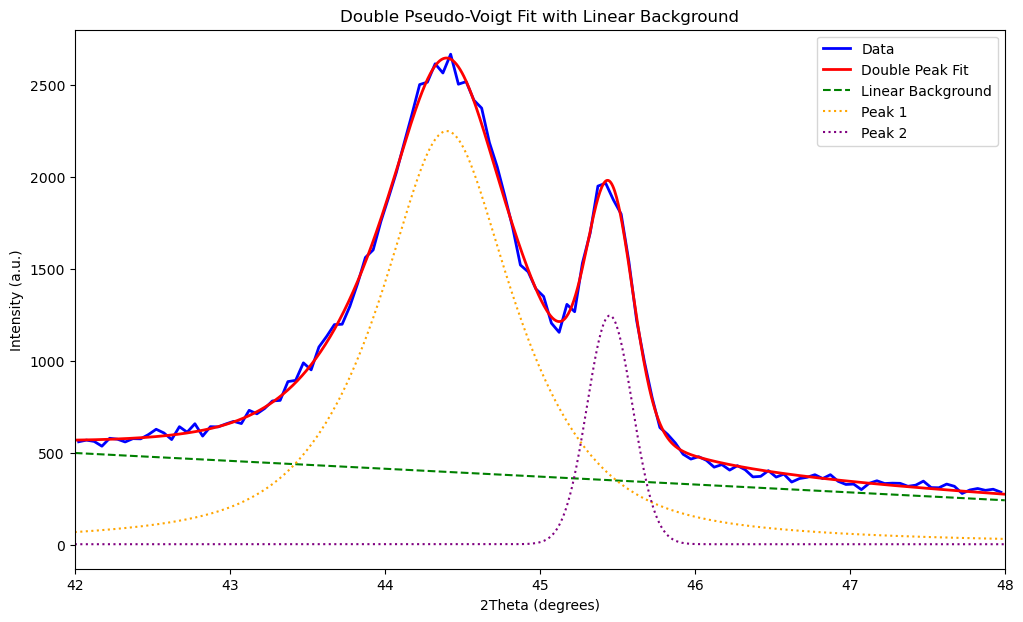

   Parameter       Value  Uncertainty
 Amplitude 1 3333.072283 2.505782e+02
    Center 1   44.400291 2.914451e-03
     Sigma 1    0.536397 3.588829e-02
     Gamma 1    0.485002 3.531168e-02
       Eta 1    0.791695 1.009190e-01
 Amplitude 2 1232.882320 3.024467e+08
    Center 2   45.451639 2.663530e-03
     Sigma 2    0.146465 2.769122e-03
     Gamma 2  122.322879 1.598653e+07
       Eta 2    0.629856 9.080259e+04
Background m  -42.841360 6.673950e+00
Background q 2297.421312 5.237567e+05

HWHM (Peak 2-1): 0.9271794478180758
HWHM (Peak 2-2): 122.32580125498879


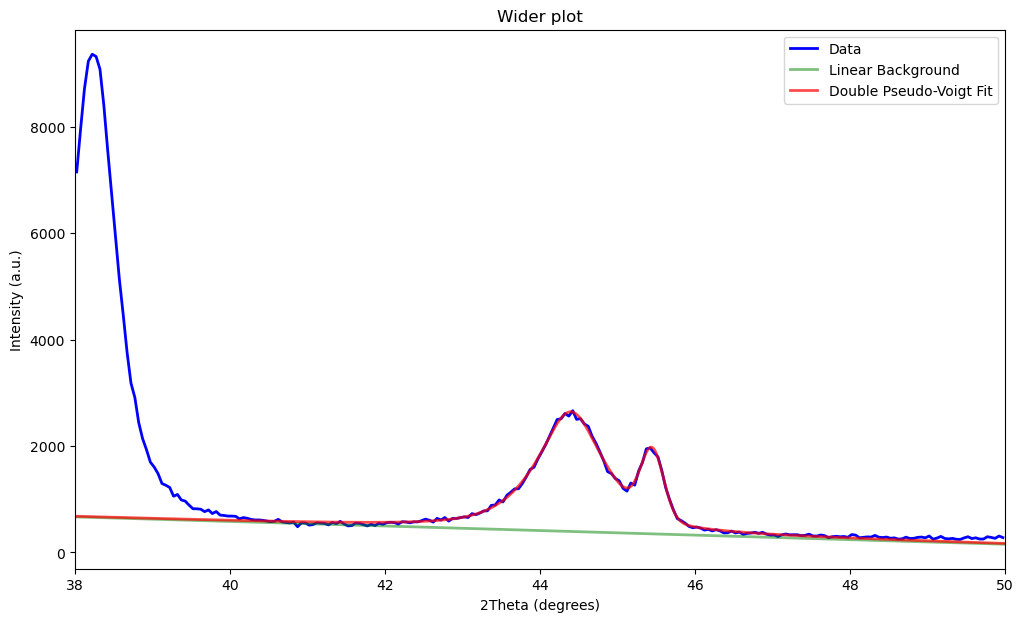

In [25]:
# Fit double peak model to peak 2 region
x_begin = 42
x_end = 48
mask = (x_data > x_begin) & (x_data < x_end)
x_filtered = x_data[mask]
y_filtered = y_data[mask]

# Initial guess for double peak: [Amplitude1, Center1, Sigma1, Gamma1, Eta1, Amplitude2, Center2, Sigma2, Gamma2, Eta2, m, q]
p0_2 = [
    3000, 44.5, 0.2, 0.2, 0.5,   # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    3000, 45.5, 0.2, 0.2, 0.5,   # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    0, 500                       # Background (m, q)
]

# Set bounds
lower_bounds = [
    0, 0, 0, 0, 0,  # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    0, 0, 0, 0, 0,  # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    -np.inf, 0      # Background (m, q)
]
upper_bounds = [
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    0, np.inf                           # Background (m, q)
]

# Fit the double peak model
bounds = (lower_bounds, upper_bounds)
p_optimal2, p_cov_2 = curve_fit(model_double, x_filtered, y_filtered, p0=p0_2, bounds=bounds, maxfev=20000)
(Amplitude_best_2_1, 
 Center_best_2_1, 
 Sigma_best_2_1, 
 Gamma_best_2_1, 
 Eta_best_2_1, 
 Amplitude_best_2_2, 
 Center_best_2_2, 
 Sigma_best_2_2, 
 Gamma_best_2_2, 
 Eta_best_2_2, 
 m2, 
 q2) = p_optimal2

# Plot the fit
x = np.linspace(42, 48, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_filtered, y_filtered, label='Data', color='blue', linewidth=2)
plt.plot(x, model_double(x, Amplitude_best_2_1, Center_best_2_1, Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1, Amplitude_best_2_2, Center_best_2_2, Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2, m2, q2), label='Double Peak Fit', color='red', linewidth=2)
plt.plot(x, linear_bg(x, m2, q2), label='Linear Background', color='green', linestyle='--')
plt.plot(x, pseudo_voigt(x, Amplitude_best_2_1, Center_best_2_1, Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1), label='Peak 1', color='orange', linestyle=':')
plt.plot(x, pseudo_voigt(x, Amplitude_best_2_2, Center_best_2_2, Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2), label='Peak 2', color='purple', linestyle=':')
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(42, 48)
plt.title('Double Pseudo-Voigt Fit with Linear Background')
plt.legend()
plt.show()

# Print the best fit parameters for Peak 2 in a table
params_2 = {
    "Parameter": [
        "Amplitude 1", "Center 1", "Sigma 1", "Gamma 1", "Eta 1",
        "Amplitude 2", "Center 2", "Sigma 2", "Gamma 2", "Eta 2",
        "Background m", "Background q"
    ],
    "Value": [
        Amplitude_best_2_1, Center_best_2_1, Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1,
        Amplitude_best_2_2, Center_best_2_2, Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2,
        m2, q2
    ],
    "Uncertainty": [
        np.sqrt(p_cov_2[i, i]) for i in range(len(p_optimal2))
    ]
}

df_params_2 = pd.DataFrame(params_2)
print(df_params_2.to_string(index=False))
print("\nHWHM (Peak 2-1):", pseudo_voigt_fwhm(Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1) * 0.5)
print("HWHM (Peak 2-2):", pseudo_voigt_fwhm(Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2) * 0.5)

xmin = 38
xmax = 50

mask_wide = (x_data > xmin) & (x_data < xmax)
x_wide = np.linspace(xmin, xmax, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_data[mask_wide], y_data[mask_wide], label='Data', color='blue', linewidth=2)
plt.plot(x_wide, linear_bg(x_wide, m2, q2), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_wide,
    model_double(x_wide, Amplitude_best_2_1, Center_best_2_1, Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1,
                 Amplitude_best_2_2, Center_best_2_2, Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2, m2, q2),
    label='Double Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(xmin, xmax)
plt.title('Wider plot')
plt.legend()
plt.show()


# Peak 3

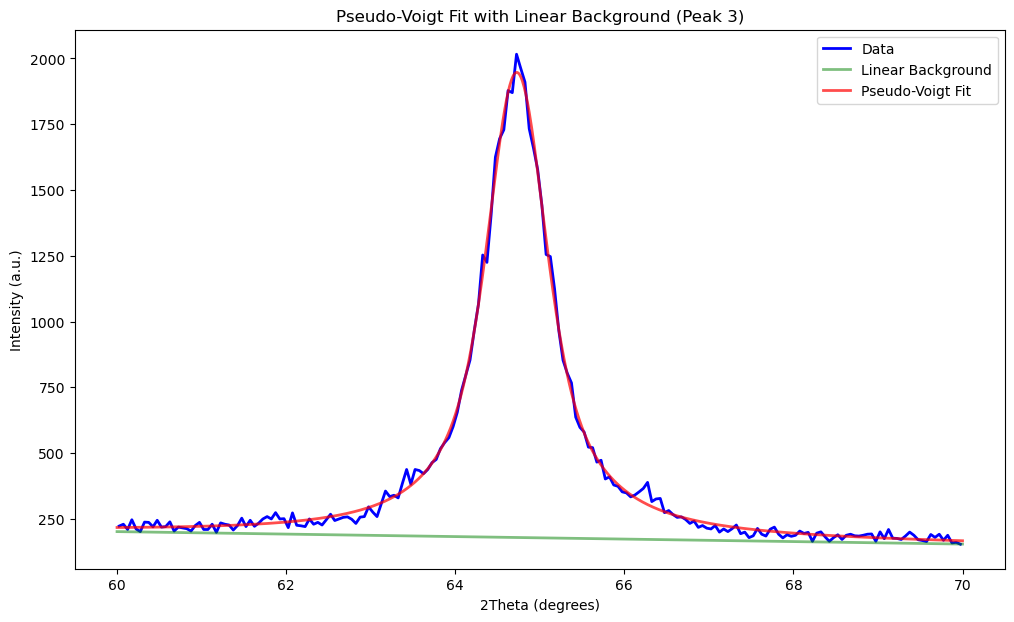

   Parameter       Value  Uncertainty
   Amplitude 2473.378662    33.265426
      Center   64.727874     0.002298
       Sigma    0.294910     0.012896
       Gamma    0.522694     0.046756
         Eta    0.858051     0.045942
Background m   -4.734905     0.602083
Background q  486.039895    39.545225

HWHM (Peak 3): 0.7026890733648934


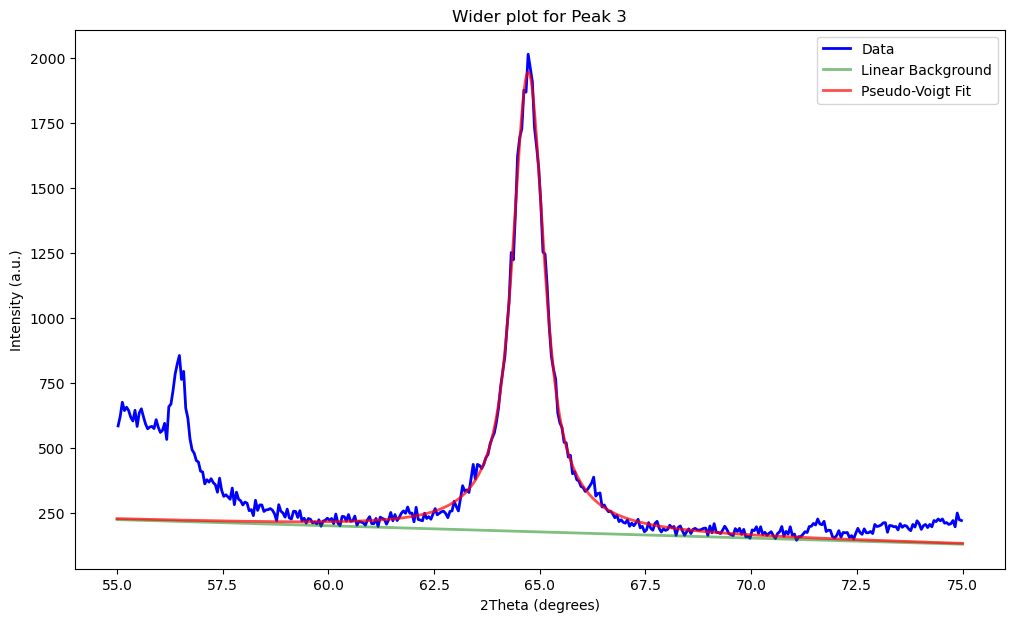

In [26]:
x_begin = 60
x_end = 70
mask = (x_data > x_begin) & (x_data < x_end)
x_filtered_3 = x_data[mask]
y_filtered_3 = y_data[mask]

# Initial guess for single peak: [amplitude, center, sigma, gamma, eta, m, q]
p0_3 = [2000, 65, 0.2, 0.2, 0.5, 0, 300]

# Set bounds
lower_bounds = [
    0, 0, 0, 0, 0,  # Peak (amplitude, center, sigma, gamma, eta)
    -np.inf, 0            # Background (m, q)
]
upper_bounds = [
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak (amplitude, center, sigma, gamma, eta)
    0, np.inf                           # Background (m, q)
]
bounds = (lower_bounds, upper_bounds)

# Fit single peak model to peak 3 region
p_optimal_3, p_cov_3 = curve_fit(model_single, x_filtered_3, y_filtered_3, p0=p0_3, bounds=bounds, maxfev=10000)
Amplitude_best_3, Center_best_3, Sigma_best_3, Gamma_best_3, Eta_best_3, m_3, q_3 = p_optimal_3


# Plot the fit
x = np.linspace(x_begin, x_end, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_filtered_3, y_filtered_3, label='Data', color='blue', linewidth=2)
plt.plot(x, linear_bg(x, m_3, q_3), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x,
    model_single(x, Amplitude_best_3, Center_best_3, Sigma_best_3, Gamma_best_3, Eta_best_3, m_3, q_3),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('Pseudo-Voigt Fit with Linear Background (Peak 3)')
plt.legend()
plt.show()

# Print the best fit parameters for Peak 3 in a table
params_3 = {
    "Parameter": [
        "Amplitude", "Center", "Sigma", "Gamma", "Eta", "Background m", "Background q"
    ],
    "Value": [
        Amplitude_best_3, Center_best_3, Sigma_best_3, Gamma_best_3, Eta_best_3, m_3, q_3
    ],
    "Uncertainty": [
        np.sqrt(p_cov_3[i, i]) for i in range(len(p_optimal_3))
    ]
}

df_params_3 = pd.DataFrame(params_3)
print(df_params_3.to_string(index=False))
print("\nHWHM (Peak 3):", pseudo_voigt_fwhm(Sigma_best_3, Gamma_best_3, Eta_best_3) * 0.5)

# Plot the fit on a wider range for Peak 3
xmin = 55
xmax = 75
mask_wide = (x_data > xmin) & (x_data < xmax)
x_wide = np.linspace(xmin, xmax, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_data[mask_wide], y_data[mask_wide], label='Data', color='blue', linewidth=2)
plt.plot(x_wide, linear_bg(x_wide, m_3, q_3), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_wide,
    model_single(x_wide, Amplitude_best_3, Center_best_3, Sigma_best_3, Gamma_best_3, Eta_best_3, m_3, q_3),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('Wider plot for Peak 3')
plt.legend()
plt.show()


# Peak 4

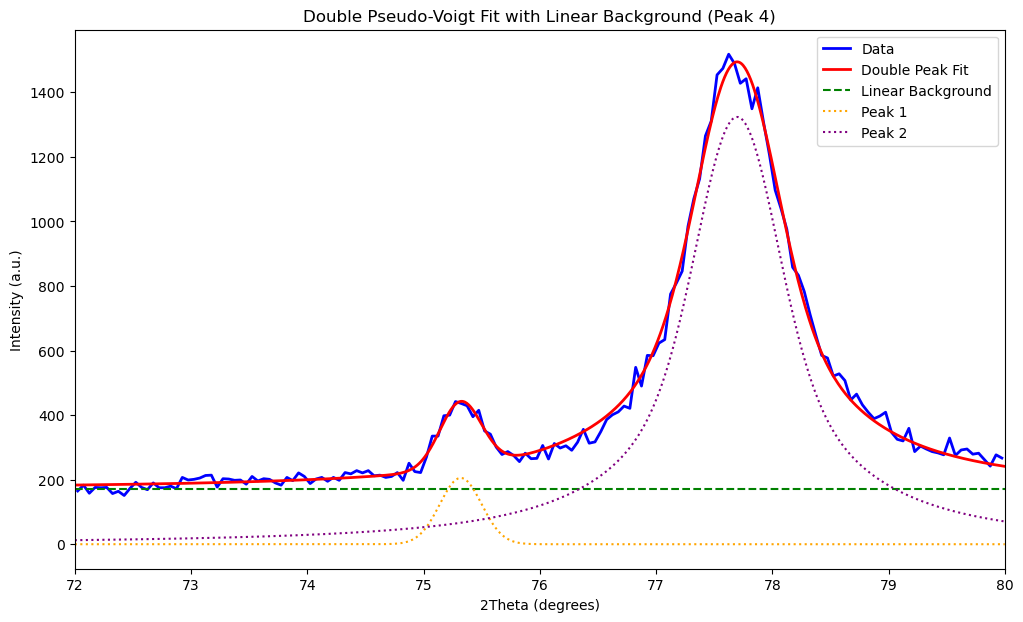

   Parameter         Value  Uncertainty
 Amplitude 1  1.872948e+02 9.829024e+07
    Center 1  7.532002e+01 1.224626e-02
     Sigma 1  1.794272e-01 1.285466e-02
     Gamma 1  7.937611e+02 7.513231e+08
       Eta 1  5.071243e-01 2.586558e+05
 Amplitude 2  2.200948e+03 1.112472e+02
    Center 2  7.769791e+01 3.469702e-03
     Sigma 2  3.217071e-01 1.423004e-02
     Gamma 2  7.610419e-01 1.529892e-01
       Eta 2  7.771855e-01 6.282082e-02
Background m -7.866461e-12 1.927197e+00
Background q  1.707587e+02 6.086578e+04

HWHM (Peak 4-1): 793.7644535347792
HWHM (Peak 4-2): 0.9242569678442965


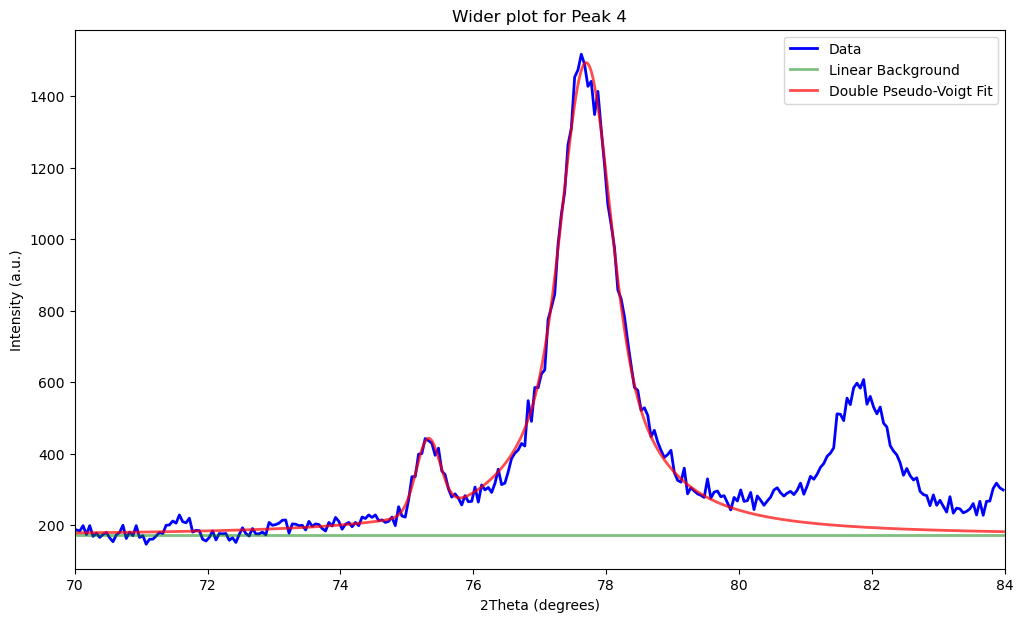

In [27]:
# Select Peak 4 region
x_begin = 72
x_end = 80
mask = (x_data > x_begin) & (x_data < x_end)
x_filtered_4 = x_data[mask]
y_filtered_4 = y_data[mask]

# Initial guess for double peak: [Amplitude1, Center1, Sigma1, Gamma1, Eta1, Amplitude2, Center2, Sigma2, Gamma2, Eta2, m, q]
p0_4 = [
    400, 75.5, 0.2, 0.2, 0.5,   # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    1500, 77.5, 0.2, 0.2, 0.5,   # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    0, 200                      # Background (m, q)
]

# Set bounds
lower_bounds_4 = [
    0, 0, 0, 0, 0,  # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    0, 0, 0, 0, 0,  # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    -np.inf, 0      # Background (m, q)
]
upper_bounds_4 = [
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak 1 (Amplitude, Center, Sigma, Gamma, Eta)
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak 2 (Amplitude, Center, Sigma, Gamma, Eta)
    0, np.inf                           # Background (m, q)
]
bounds_4 = (lower_bounds_4, upper_bounds_4)

# Fit the double peak model
p_optimal_4, p_cov_4 = curve_fit(model_double, x_filtered_4, y_filtered_4, p0=p0_4, bounds=bounds_4, maxfev=20000)
(Amplitude_best_4_1, 
 Center_best_4_1, 
 Sigma_best_4_1, 
 Gamma_best_4_1, 
 Eta_best_4_1, 
 Amplitude_best_4_2, 
 Center_best_4_2, 
 Sigma_best_4_2, 
 Gamma_best_4_2, 
 Eta_best_4_2, 
 m4, 
 q4) = p_optimal_4

# Plot the fit
x = np.linspace(x_begin, x_end, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_filtered_4, y_filtered_4, label='Data', color='blue', linewidth=2)
plt.plot(x, model_double(x, Amplitude_best_4_1, Center_best_4_1, Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1,
                         Amplitude_best_4_2, Center_best_4_2, Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2, m4, q4),
         label='Double Peak Fit', color='red', linewidth=2)
plt.plot(x, linear_bg(x, m4, q4), label='Linear Background', color='green', linestyle='--')
plt.plot(x, pseudo_voigt(x, Amplitude_best_4_1, Center_best_4_1, Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1),
         label='Peak 1', color='orange', linestyle=':')
plt.plot(x, pseudo_voigt(x, Amplitude_best_4_2, Center_best_4_2, Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2),
         label='Peak 2', color='purple', linestyle=':')
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(x_begin, x_end)
plt.title('Double Pseudo-Voigt Fit with Linear Background (Peak 4)')
plt.legend()
plt.show()

# Print the best fit parameters for peak 4 as a DataFrame (following the same pattern as above)
params_4 = {
    "Parameter": [
        "Amplitude 1", "Center 1", "Sigma 1", "Gamma 1", "Eta 1",
        "Amplitude 2", "Center 2", "Sigma 2", "Gamma 2", "Eta 2",
        "Background m", "Background q"
    ],
    "Value": [
        Amplitude_best_4_1, Center_best_4_1, Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1,
        Amplitude_best_4_2, Center_best_4_2, Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2,
        m4, q4
    ],
    "Uncertainty": [
        np.sqrt(p_cov_4[i, i]) for i in range(len(p_optimal_4))
    ]
}

df_params_4 = pd.DataFrame(params_4)
print(df_params_4.to_string(index=False))
print("\nHWHM (Peak 4-1):", pseudo_voigt_fwhm(Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1) * 0.5)
print("HWHM (Peak 4-2):", pseudo_voigt_fwhm(Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2) * 0.5)

# Plot the fit on a wider range for Peak 4
xmin = 70
xmax = 84
mask_wide_4 = (x_data > xmin) & (x_data < xmax)
x_wide_4 = np.linspace(xmin, xmax, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_data[mask_wide_4], y_data[mask_wide_4], label='Data', color='blue', linewidth=2)
plt.plot(x_wide_4, linear_bg(x_wide_4, m4, q4), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_wide_4,
    model_double(x_wide_4, Amplitude_best_4_1, Center_best_4_1, Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1,
                 Amplitude_best_4_2, Center_best_4_2, Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2, m4, q4),
    label='Double Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(xmin, xmax)
plt.title('Wider plot for Peak 4')
plt.legend()
plt.show()

# Peak 5

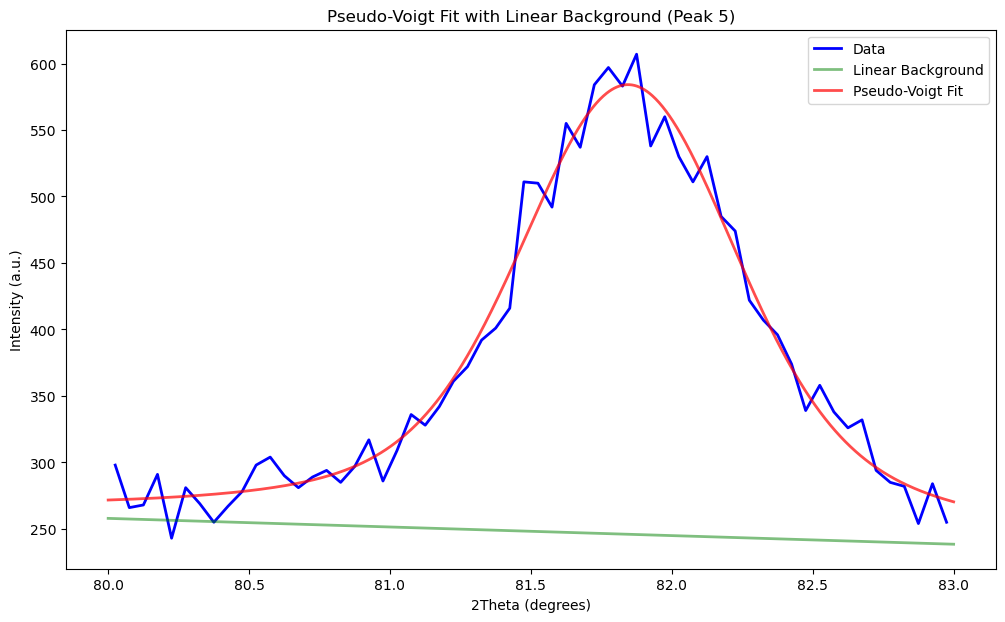

   Parameter      Value  Uncertainty
   Amplitude 447.682930   155.858003
      Center  81.847507     0.010663
       Sigma   0.360488     0.074658
       Gamma   0.611162     0.567815
         Eta   0.599633     0.245305
Background m  -6.481933     4.681759
Background q 776.476587   366.804835

HWHM (Peak 5): 0.8368177816304485


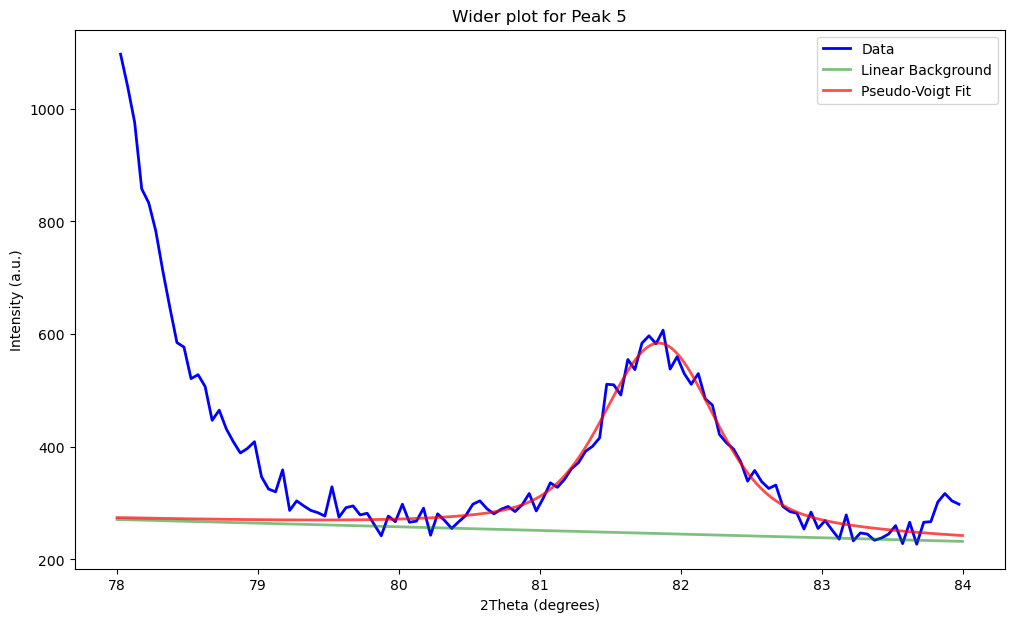

In [28]:
# Select Peak 5 region (single peak between 80 and 83)
x_begin_5 = 80
x_end_5 = 83
mask_5 = (x_data > x_begin_5) & (x_data < x_end_5)
x_filtered_5 = x_data[mask_5]
y_filtered_5 = y_data[mask_5]

# Initial guess for single peak: [amplitude, center, sigma, gamma, eta, m, q]
p0_5 = [400, 81.5, 0.2, 0.2, 0.5, 0, 200]

# Set bounds
lower_bounds_5 = [
    0, 0, 0, 0, 0,      # Peak (amplitude, center, sigma, gamma, eta)
    -np.inf, 0          # Background (m, q)
]
upper_bounds_5 = [
    np.inf, np.inf, np.inf, np.inf, 1,  # Peak (amplitude, center, sigma, gamma, eta)
    0, np.inf                           # Background (m, q)
]
bounds_5 = (lower_bounds_5, upper_bounds_5)

# Fit single peak model to peak 5 region
p_optimal_5, p_cov_5 = curve_fit(model_single, x_filtered_5, y_filtered_5, p0=p0_5, bounds=bounds_5, maxfev=10000)
Amplitude_best_5, Center_best_5, Sigma_best_5, Gamma_best_5, Eta_best_5, m_5, q_5 = p_optimal_5

# Plot the fit
x_5 = np.linspace(x_begin_5, x_end_5, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_filtered_5, y_filtered_5, label='Data', color='blue', linewidth=2)
plt.plot(x_5, linear_bg(x_5, m_5, q_5), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_5,
    model_single(x_5, Amplitude_best_5, Center_best_5, Sigma_best_5, Gamma_best_5, Eta_best_5, m_5, q_5),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('Pseudo-Voigt Fit with Linear Background (Peak 5)')
plt.legend()
plt.show()

# Print the best fit parameters for Peak 5 in a table
params_5 = {
    "Parameter": [
        "Amplitude", "Center", "Sigma", "Gamma", "Eta", "Background m", "Background q"
    ],
    "Value": [
        Amplitude_best_5, Center_best_5, Sigma_best_5, Gamma_best_5, Eta_best_5, m_5, q_5
    ],
    "Uncertainty": [
        np.sqrt(p_cov_5[i, i]) for i in range(len(p_optimal_5))
    ]
}

df_params_5 = pd.DataFrame(params_5)
print(df_params_5.to_string(index=False))
print("\nHWHM (Peak 5):", pseudo_voigt_fwhm(Sigma_best_5, Gamma_best_5, Eta_best_5) * 0.5)

# Plot the fit on a wider range for Peak 5
xmin_5 = 78
xmax_5 = 84
mask_wide_5 = (x_data > xmin_5) & (x_data < xmax_5)
x_wide_5 = np.linspace(xmin_5, xmax_5, 1000)
plt.figure(figsize=(12, 7))
plt.plot(x_data[mask_wide_5], y_data[mask_wide_5], label='Data', color='blue', linewidth=2)
plt.plot(x_wide_5, linear_bg(x_wide_5, m_5, q_5), label='Linear Background', color='green', alpha=0.5, linewidth=2)
plt.plot(
    x_wide_5,
    model_single(x_wide_5, Amplitude_best_5, Center_best_5, Sigma_best_5, Gamma_best_5, Eta_best_5, m_5, q_5),
    label='Pseudo-Voigt Fit',
    color='red',
    alpha=0.7,
    linewidth=2
)
plt.xlabel('2Theta (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title('Wider plot for Peak 5')
plt.legend()
plt.show()

# Analysis of the peaks

In [29]:
import numpy as np

print("Best fit centers for all peaks:")
hwhm_1 = pseudo_voigt_fwhm(Sigma_best_1, Gamma_best_1, Eta_best_1) * 0.5
hwhm_2_1 = pseudo_voigt_fwhm(Sigma_best_2_1, Gamma_best_2_1, Eta_best_2_1) * 0.5
hwhm_2_2 = pseudo_voigt_fwhm(Sigma_best_2_2, Gamma_best_2_2, Eta_best_2_2) * 0.5
hwhm_3 = pseudo_voigt_fwhm(Sigma_best_3, Gamma_best_3, Eta_best_3) * 0.5
hwhm_4_1 = pseudo_voigt_fwhm(Sigma_best_4_1, Gamma_best_4_1, Eta_best_4_1) * 0.5
hwhm_4_2 = pseudo_voigt_fwhm(Sigma_best_4_2, Gamma_best_4_2, Eta_best_4_2) * 0.5
hwhm_5 = pseudo_voigt_fwhm(Sigma_best_5, Gamma_best_5, Eta_best_5) * 0.5


print(f"Peak 1 center: {Center_best_1:.1f} ± {hwhm_1:.1f} deg = {np.deg2rad(Center_best_1):.2f} ± {np.deg2rad(hwhm_1):.2f} rad")
print(f"Peak 2 center: {Center_best_2_1:.1f} ± {hwhm_2_1:.1f} deg = {np.deg2rad(Center_best_2_1):.2f} ± {np.deg2rad(hwhm_2_1):.2f} rad")
print(f"Peak 3 center: {Center_best_3:.1f} ± {hwhm_3:.1f} deg = {np.deg2rad(Center_best_3):.2f} ± {np.deg2rad(hwhm_3):.2f} rad")
print(f"Peak 4 center: {Center_best_4_2:.1f} ± {hwhm_4_2:.1f} deg = {np.deg2rad(Center_best_4_2):.2f} ± {np.deg2rad(hwhm_4_2):.2f} rad")
print(f"Peak 5 center: {Center_best_5:.1f} ± {hwhm_5:.1f} deg = {np.deg2rad(Center_best_5):.2f} ± {np.deg2rad(hwhm_5):.2f} rad")
print("")



Best fit centers for all peaks:
Peak 1 center: 38.2 ± 0.6 deg = 0.67 ± 0.01 rad
Peak 2 center: 44.4 ± 0.9 deg = 0.77 ± 0.02 rad
Peak 3 center: 64.7 ± 0.7 deg = 1.13 ± 0.01 rad
Peak 4 center: 77.7 ± 0.9 deg = 1.36 ± 0.02 rad
Peak 5 center: 81.8 ± 0.8 deg = 1.43 ± 0.01 rad



# Scherrer & fit

Diameters from the single peaks:
	7.268e-09 m
	4.576e-09 m
	6.618e-09 m
	5.457e-09 m
	6.212e-09 m
Mean diameter from single peaks: 6.026e-09 m ± 4.667e-10 m
Y values with errors:
	1.441e-02 ± 1.429e-03
	2.560e-02 ± 4.844e-03
	1.674e-02 ± 3.727e-03
	2.146e-02 ± 7.986e-03
	1.851e-02 ± 6.714e-03
Fitted D: 1.336e-08 ± 8.166e-09 m
Fitted epsilon: 3.665e-03 ± 4.079e-03


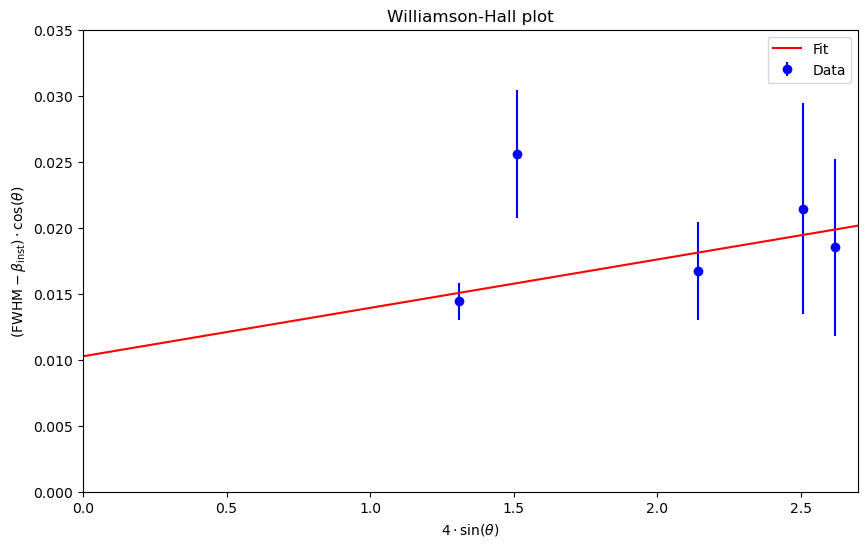

In [30]:
# Arrays for values
sigmas = [Sigma_best_1, Sigma_best_2_1, Sigma_best_3, Sigma_best_4_2, Sigma_best_5]
gammas = [Gamma_best_1, Gamma_best_2_1, Gamma_best_3, Gamma_best_4_2, Gamma_best_5]
etas = [Eta_best_1, Eta_best_2_1, Eta_best_3, Eta_best_4_2, Eta_best_5]
centers = [Center_best_1, Center_best_2_1, Center_best_3, Center_best_4_2, Center_best_5]

sigmas = np.array(sigmas)
gammas = np.array(gammas)
etas = np.array(etas)
centers = np.array(centers)

# k times lambda
c = 0.89 * 0.15406e-9

# fwhm calculation
fwhm = pseudo_voigt_fwhm(sigmas, gammas, etas)

# Single diameters
diams = c / (np.deg2rad(fwhm) * np.cos(np.deg2rad(centers) / 2))
print(f"Diameters from the single peaks:")
for d in diams:
    print(f"\t{d:.3e} m")
print(f"Mean diameter from single peaks: {np.mean(diams):.3e} m ± {np.std(diams, ddof=1)/np.sqrt(len(diams)):.3e} m")

# array for x and y and errors on y
y = np.deg2rad(fwhm - 0.27)*np.cos(np.deg2rad(centers) / 2)
x = 4 * np.sin(np.deg2rad(centers) / 2)
y_sigma = y * np.tan(np.deg2rad(centers/2)) * fwhm / 4

# scherrer function
def scherrer_func(x, D, epsilon):
    return c / D + x * epsilon

# Fit the function to the data
[D_fit, epsilon_fit], pcov = curve_fit(scherrer_func, x, y, sigma=y_sigma, p0=[10e-9, 0.001])
# popt, pcov = curve_fit(scherrer_func, x, y, p0=[10e-9, 0.001])

print("Y values with errors:")
for y_c, y_s in zip(y, y_sigma):
    print(f"\t{y_c:.3e} ± {y_s:.3e}")

# Calculate uncertainties (standard deviations) for the fitted parameters
D_fit_err, epsilon_fit_err = np.sqrt(np.diag(pcov))
print(f"Fitted D: {D_fit:.3e} ± {D_fit_err:.3e} m")
print(f"Fitted epsilon: {epsilon_fit:.3e} ± {epsilon_fit_err:.3e}")

x_ax = np.linspace(0, 2.7, 100)

# Plot the data and the fit
plt.figure(figsize=(10, 6))
# plt.scatter(x, y, label='Data', color='blue')
plt.errorbar(x, y, yerr=y_sigma, fmt='o', color='blue', label='Data')
plt.plot(x_ax, scherrer_func(x_ax, D_fit, epsilon_fit), label='Fit', color='red')
plt.xlabel(r'$4\cdot\sin(\theta)$')
plt.ylabel(r'$(\mathrm{FWHM} - \beta_\mathrm{inst}) \cdot \cos(\theta)$')
plt.xlim(0, 2.7)
plt.ylim(0, 0.035)
plt.title('Williamson-Hall plot')
plt.legend()
plt.show()

# New lattice constant

In [31]:
# X-ray wavelength (Cu Kα)
wavelength = 0.15406e-9  # meters

# Peak centers from your fits
peak_centers = np.array([Center_best_1, Center_best_2_1, Center_best_3, Center_best_4_2, Center_best_5])

# Miller indices for each peak
# These are typical for cubic crystals - adjust based on your specific material
miller_indices = [
    (1, 1, 1),  # Peak 1
    (2, 0, 0),  # Peak 2
    (2, 2, 0),  # Peak 3
    (3, 1, 1),  # Peak 4
    (2, 2, 2),  # Peak 5
]

# Calculate lattice parameter A for each peak
lattice_parameters = []

for i, (center, (h, k, l)) in enumerate(zip(peak_centers, miller_indices)):
    # Convert 2theta to theta in radians
    theta_rad = np.deg2rad(center / 2)
    
    # Calculate d-spacing using Bragg's law: nλ = 2d sinθ
    d_spacing = wavelength / (2 * np.sin(theta_rad))
    
    # Calculate lattice parameter using: d = a / sqrt(h² + k² + l²)
    hkl_magnitude = np.sqrt(h**2 + k**2 + l**2)
    lattice_param = d_spacing * hkl_magnitude
    
    lattice_parameters.append(lattice_param)
    
    print(f"Peak {i+1}: 2θ = {center:.3f}°, (h,k,l) = {miller_indices[i]}, d = {d_spacing*1e10:.3f} Å, a = {lattice_param*1e10:.3f} Å")

lattice_parameters = np.array(lattice_parameters)

# Calculate mean and standard deviation
mean_lattice_param = np.mean(lattice_parameters)
std_lattice_param = np.std(lattice_parameters, ddof=1)  # Sample standard deviation
std_error = std_lattice_param / np.sqrt(len(lattice_parameters))  # Standard error of the mean

print(f"\nLattice parameters for each peak:")
for i, a in enumerate(lattice_parameters):
    print(f"Peak {i+1}: a = {a*1e10:.4f} Å")

print(f"\nMean lattice parameter: a = {mean_lattice_param*1e10:.4f} ± {std_error*1e10:.4f} Å")
print(f"Standard deviation: {std_lattice_param*1e10:.4f} Å")

# Create a summary table
summary_data = {
    'Peak': [f'Peak {i+1}' for i in range(len(peak_centers))],
    '2θ (°)': [f'{center:.3f}' for center in peak_centers],
    '(h,k,l)': [str(hkl) for hkl in miller_indices],
    'd-spacing (Å)': [f'{wavelength/(2*np.sin(np.deg2rad(center/2)))*1e10:.3f}' for center in peak_centers],
    'Lattice parameter a (Å)': [f'{a*1e10:.4f}' for a in lattice_parameters]
}

df_summary = pd.DataFrame(summary_data)
print(f"\nSummary Table:")
print(df_summary.to_string(index=False))

Peak 1: 2θ = 38.240°, (h,k,l) = (1, 1, 1), d = 2.352 Å, a = 4.073 Å
Peak 2: 2θ = 44.400°, (h,k,l) = (2, 0, 0), d = 2.039 Å, a = 4.077 Å
Peak 3: 2θ = 64.728°, (h,k,l) = (2, 2, 0), d = 1.439 Å, a = 4.070 Å
Peak 4: 2θ = 77.698°, (h,k,l) = (3, 1, 1), d = 1.228 Å, a = 4.073 Å
Peak 5: 2θ = 81.848°, (h,k,l) = (2, 2, 2), d = 1.176 Å, a = 4.074 Å

Lattice parameters for each peak:
Peak 1: a = 4.0733 Å
Peak 2: a = 4.0774 Å
Peak 3: a = 4.0702 Å
Peak 4: a = 4.0729 Å
Peak 5: a = 4.0736 Å

Mean lattice parameter: a = 4.0734 ± 0.0011 Å
Standard deviation: 0.0026 Å

Summary Table:
  Peak 2θ (°)   (h,k,l) d-spacing (Å) Lattice parameter a (Å)
Peak 1 38.240 (1, 1, 1)         2.352                  4.0733
Peak 2 44.400 (2, 0, 0)         2.039                  4.0774
Peak 3 64.728 (2, 2, 0)         1.439                  4.0702
Peak 4 77.698 (3, 1, 1)         1.228                  4.0729
Peak 5 81.848 (2, 2, 2)         1.176                  4.0736
